# Wine Quality (Classification)
## Data Cleaning, Exploration and Wrangling

### Source
- https://archive.ics.uci.edu/ml/datasets/Wine+Quality
- http://www3.dsi.uminho.pt/pcortez/wine/

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

from eda import plot_corr_mat, evaluate_regression, plot_regression, skew_kurt, coeficient_importance
from pipelines.transformation import remove_outliers_iqr
from models.evaluators import evaluate_classification

In [2]:
df_rd = pd.read_csv('lake/wine_quality/winequality-red.csv')
df_wt = pd.read_csv('lake/wine_quality/winequality-white.csv')
print(df_rd.shape, df_wt.shape)

(1599, 12) (4898, 12)


In [3]:
df_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Merge Datasets

In [4]:
df_rd['type'] = 'red'
df_wt['type'] = 'white'

In [5]:
df = pd.concat([df_rd, df_wt], axis=0).reindex()

### Specific Transformations

In [6]:
# Categorize Wine Quality for Classification
df['quality_cat'] = pd.cut(x=df['quality'], bins=[0,5,7,10], labels=[0,1,2])

### Type of Features

In [7]:
print(df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type', 'quality_cat'],
      dtype='object')


In [8]:
#Numerical Features
num_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol', 'quality']
df[num_cols].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


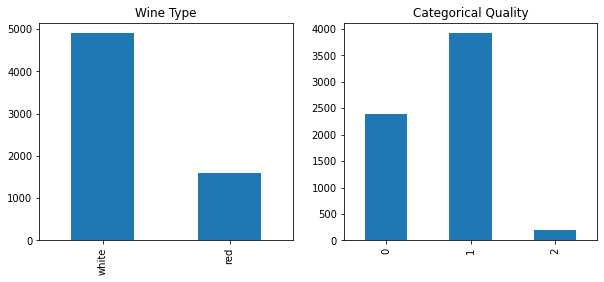

In [9]:
# Categorical
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
df.type.value_counts().plot.bar(ax=ax1, title='Wine Type')
df.quality_cat.value_counts().sort_index().plot.bar(ax=ax2, title='Categorical Quality');

### Missing Values

In [10]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
quality_cat             0
dtype: int64

### Duplicated Values

In [11]:
# Red Wines
df_rd[df_rd.duplicated(keep=False)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5,red
11,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5,red
22,7.9,0.430,0.21,1.6,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5,red
1579,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5,red
1581,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5,red
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,red


In [12]:
# White Wines
df_wt[df_wt.duplicated(keep=False)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.800000,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.500000,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4851,6.4,0.33,0.44,8.9,0.055,52.0,164.0,0.99488,3.10,0.48,9.600000,5,white
4855,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6,white
4856,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6,white
4879,6.6,0.34,0.40,8.1,0.046,68.0,170.0,0.99494,3.15,0.50,9.533333,6,white


### Feature Exploration: Univariate

<AxesSubplot:xlabel='quality', ylabel='count'>

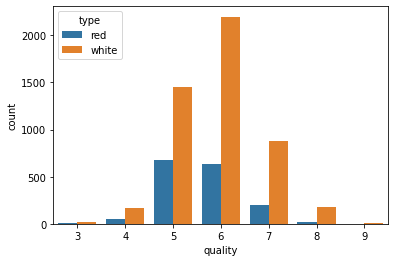

In [13]:
sns.countplot(df["quality"], hue="type", data=df)

<AxesSubplot:xlabel='quality_cat', ylabel='count'>

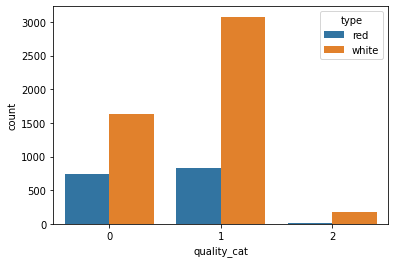

In [14]:
sns.countplot(df["quality_cat"], hue="type", data=df)

### Outliers Analysis

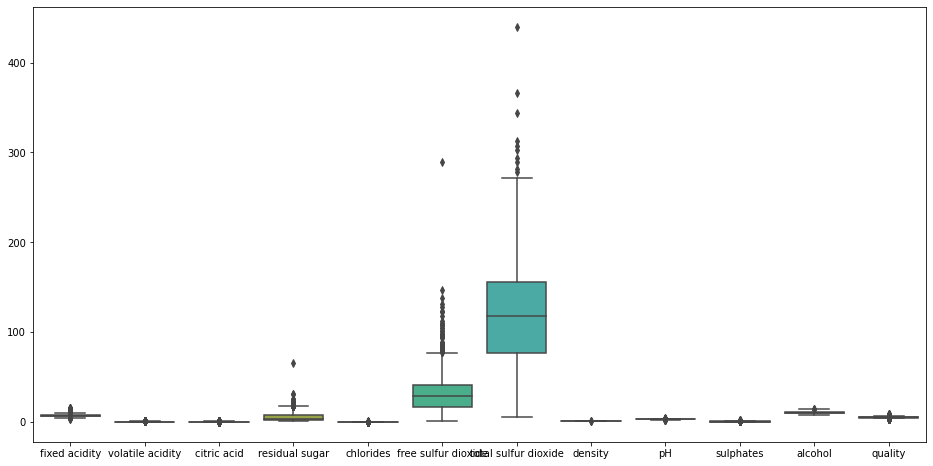

In [15]:
fig =plt.figure(figsize=(16,8))
sns.boxplot(data=df[num_cols]);

In [16]:
outlier_cols = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide']
skew_kurt(df[outlier_cols])

,kurtosis,skewness
residual sugar,4.359272,1.435404
free sulfur dioxide,7.906238,1.220066
total sulfur dioxide,-0.371664,-0.001177


In [17]:
skew_kurt(np.log1p(df[outlier_cols]))

,kurtosis,skewness
residual sugar,-1.160624,0.414917
free sulfur dioxide,0.124574,-0.721434
total sulfur dioxide,1.274064,-1.350357


### Feeature Exploration: Bivariate Analysis

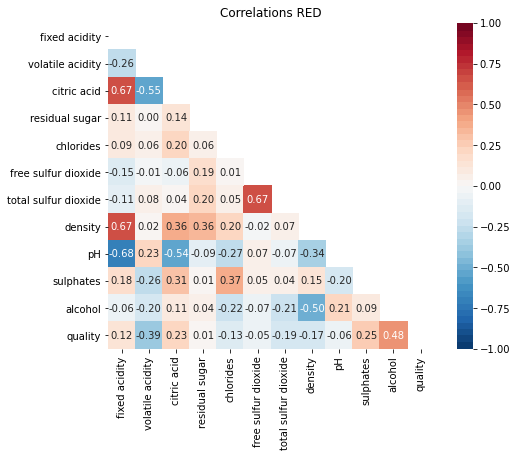

In [18]:
plot_corr_mat(df_rd, "Correlations RED")

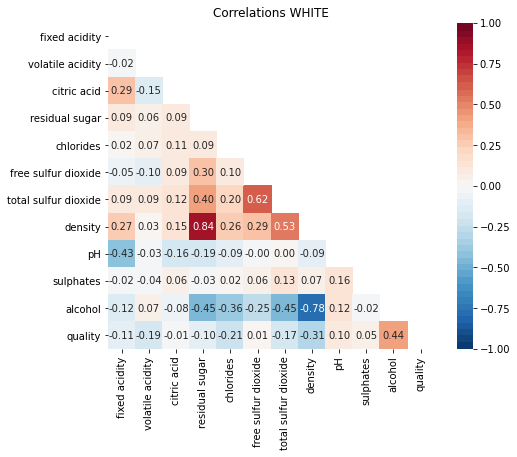

In [19]:
plot_corr_mat(df_wt, "Correlations WHITE")

In [23]:
from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_widgets()

## Building Models

In [25]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol']
X = df[features]
y = df.quality_cat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape)
print(y_test.shape, y_test.shape)

(4872, 11) (1625, 11)
(1625,) (1625,)


In [26]:
# Raw Features
trees = ExtraTreesClassifier()
trees.fit(X_train,y_train)
y_pred = trees.predict(X_test)
pd.DataFrame({'Actuals': y_test, 'Predictions': y_pred})

,Actuals,Predictions
3717,1,0
3611,1,1
1919,1,0
23,0,0
844,2,2
...,...,...
553,1,0
2420,1,1
2133,1,1
1315,1,1


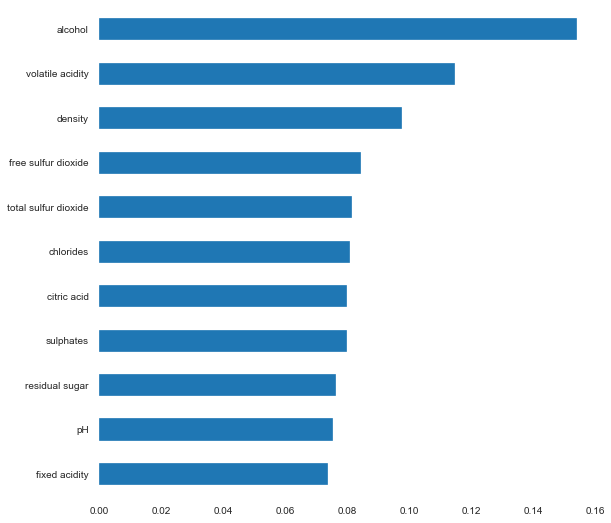

In [37]:
def plot_importances(weights, columns, excluded_cols=[]):
    importances = pd.Series(weights, index=columns)
    selected_cols = [col for col in columns if col not in excluded_cols]
    fig, ax = plt.subplots(figsize=(9,9))
    importances[selected_cols].sort_values(ascending=True).plot.barh(ax=ax)
plot_importances(trees.feature_importances_, features)

In [ ]:
evaluate_regression(y_test, y_pred)
plot_regression(y_test, y_pred)

In [40]:
evaluate_classification(y_test, y_pred, labels=[0,1,2])

Accuracy: 79.69
Confusion Matrix
             actuals         
                   0    1   2
prediction 0     422  175   0
           1     122  855   1
           2       0   32  18
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       597
           1       0.81      0.87      0.84       978
           2       0.95      0.36      0.52        50

    accuracy                           0.80      1625
   macro avg       0.84      0.65      0.70      1625
weighted avg       0.80      0.80      0.79      1625

